## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from random import random
import time
import scipy
import scipy.sparse.linalg
from scipy.sparse import coo_matrix, lil_matrix, csr_matrix
from scipy.sparse.linalg import lsqr
import numpy as np
import scipy.sparse
import scipy.sparse.linalg

import utils

## Part 1 Toy Problem (20 pts)

In [2]:
def toy_reconstruct(source_image: np.ndarray) -> np.ndarray:
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a 
    mistake, so let's start with a toy example. Reconstruct this image from its gradient values, 
    plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the 
    value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more 
    objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """

    rows, columns = source_image.shape

    # Count equations: one for each horizontal pair + one for each vertical pair + one anchor
    number_of_equations = rows * (columns - 1) + (rows - 1) * columns + 1

    coefficient_matrix = scipy.sparse.lil_matrix(
        (number_of_equations, rows * columns), dtype="float64"
    )
    solutions_matrix = np.zeros((number_of_equations, 1), dtype="float64")

    def linear_index(y: int, x: int) -> int:
        """Map 2D coordinates (y, x) to a 1D linear index."""
        return y * columns + x

    equation_row = 0

    # Horizontal gradient constraints: v(x+1, y) - v(x, y) = s(x+1, y) - s(x, y)
    for y in range(rows):
        for x in range(columns - 1):
            left_index = linear_index(y, x)
            right_index = linear_index(y, x + 1)

            coefficient_matrix[equation_row, right_index] = 1.0
            coefficient_matrix[equation_row, left_index] = -1.0
            solutions_matrix[equation_row, 0] = source_image[y, x + 1] - source_image[y, x]
            equation_row += 1

    # Vertical gradient constraints: v(x, y+1) - v(x, y) = s(x, y+1) - s(x, y)
    for y in range(rows - 1):
        for x in range(columns):
            top_index = linear_index(y, x)
            bottom_index = linear_index(y + 1, x)

            coefficient_matrix[equation_row, bottom_index] = 1.0
            coefficient_matrix[equation_row, top_index] = -1.0
            solutions_matrix[equation_row, 0] = source_image[y + 1, x] - source_image[y, x]
            equation_row += 1

    # Intensity anchor: v(0, 0) = s(0, 0)
    coefficient_matrix[equation_row, linear_index(0, 0)] = 1.0
    solutions_matrix[equation_row, 0] = source_image[0, 0]

    # Solve least squares
    output = scipy.sparse.linalg.lsqr(
        coefficient_matrix.tocsr(),
        solutions_matrix[:, 0],
        atol=1e-7,
        btol=1e-7,
    )[0]

    reconstructed_image = output.reshape((rows, columns))

    return reconstructed_image


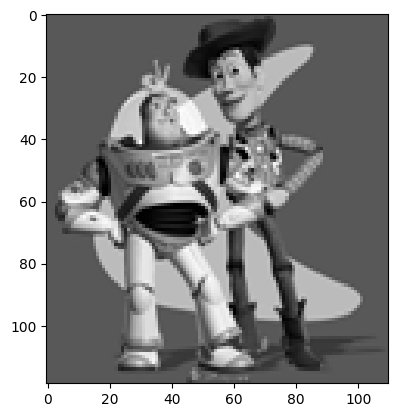

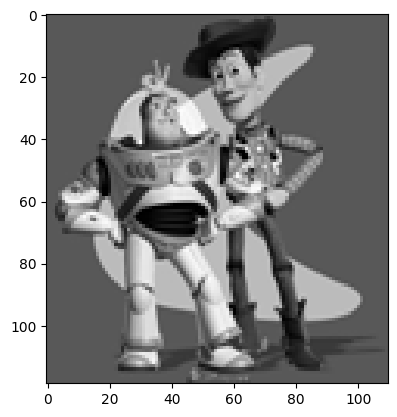

Max error is:  6.733238188977309e-05


In [3]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

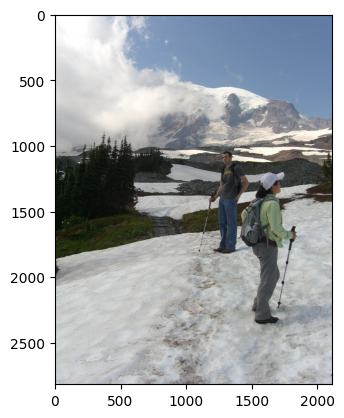

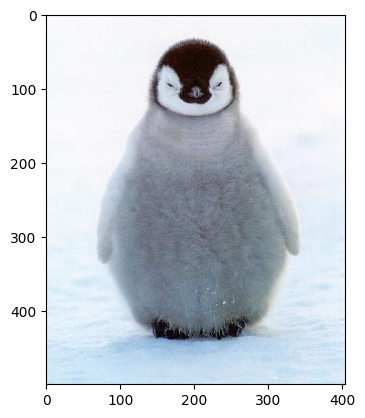

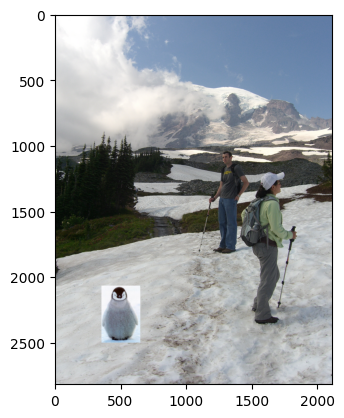

In [15]:
background_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

xs = (65, 359, 359, 65)
ys = (24, 24, 457, 457)
object_mask = utils.get_mask(ys, xs, object_img)
bottom_center = (500, 2500) # (x,y)

object_img, object_mask = utils.crop_object_img(object_img, object_mask)
position = utils.upper_left_background_rc(object_mask, bottom_center)
plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, position))



## Part 2 Poisson Blending (50 pts)

In [16]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO 



In [ ]:

def poisson_blend(object_img, object_mask, bg_img, position, mixed_gradients: bool = False):
    """
    Returns a Poisson blended image with masked object_img over bg_img at the
    position specified by bg_ul (row, col), using source-gradient guidance.

    This implementation:
      - Works on grayscale or color images (channels handled independently).
      - Uses 4-neighborhood Poisson blending (Perez et al. 2003).
      - Builds a sparse least-squares system with lsqr.
      - Blends only within the overlap of object_img and bg_img.

    Args:
        object_img: HxW (grayscale) or HxWxC (color) float array in [0, 1].
        object_mask: HxW boolean (or 0/1) array; True indicates blending region.
        bg_img: HxW (grayscale) or HxWxC (color) float array in [0, 1].
        bg_ul: tuple (row, col) giving background coordinate that aligns with
               object_img coordinate (0, 0).

    Returns:
        A new image with the same shape as bg_img containing the blended result.
    """
    # ---- Validation and normalization ----
    if object_img is None or object_mask is None or bg_img is None:
        raise ValueError("object_img, object_mask, and bg_img must be provided.")

    if object_img.ndim not in (2, 3):
        raise ValueError("object_img must be HxW (grayscale) or HxWxC (color).")

    if bg_img.ndim not in (2, 3):
        raise ValueError("bg_img must be HxW (grayscale) or HxWxC (color).")

    if object_img.ndim == 2 and bg_img.ndim == 3:
        # Promote object to color if background is color
        object_img = object_img[..., None]

    if object_img.ndim == 3 and bg_img.ndim == 2:
        # Promote background to color if object is color
        bg_img = bg_img[..., None]

    if object_mask.ndim != 2:
        raise ValueError("object_mask must be a 2D array (HxW).")

    if object_img.shape[:2] != object_mask.shape:
        raise ValueError("object_img height/width must match object_mask.")

    if not (isinstance(position, tuple) and len(position) == 2):
        raise ValueError("bg_ul must be a (row, col) tuple.")

    if not np.issubdtype(object_img.dtype, np.floating) or not np.issubdtype(bg_img.dtype, np.floating):
        raise TypeError("object_img and bg_img must be floating-point arrays.")

    object_mask = object_mask.astype(bool)

    # Ensure we always have a channel dimension (C = 1 for grayscale)
    if object_img.ndim == 2:
        object_img = object_img[..., None]
    if bg_img.ndim == 2:
        bg_img = bg_img[..., None]

    object_height, object_width, number_of_channels = object_img.shape
    bg_height, bg_width, bg_channels = bg_img.shape

    # ---- Compute overlap between object placement and background bounds ----
    object_patch = object_img[0:object_height, 0:object_width, :]
    mask_patch = object_mask[0:object_height, 0:object_width]
    background_patch = bg_img[
        position[0]:position[0] + object_height, 
        position[1]:position[1] + object_width, 
        :
    ].copy()

    patch_height, patch_width = mask_patch.shape

    # im2var code from the hints doc
    number_of_variables = object_mask.sum()
    im2var = -np.ones((patch_height, patch_width), dtype=np.int64)
    im2var[mask_patch] = np.arange(number_of_variables)

    # ---- Assemble the sparse system A * x = b for each channel ----
    # For each masked pixel i and each 4-neighbor j:
    #   If neighbor j is inside the mask:      v_i - v_j = s_i - s_j
    #   If neighbor j is outside the mask:     v_i       = s_i - s_j + t_j
    # where s are object intensities, t are background intensities aligned under the object.
    #
    # We add one equation per masked pixel per valid neighbor (up, down, left, right).
    neighbor_offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    # Count equations to preallocate (each masked pixel contributes up to 4 equations)
    number_of_equations = 0
    for row in range(patch_height):
        for col in range(patch_width):
            if not mask_patch[row, col]:
                continue
            for dy, dx in neighbor_offsets:
                if 0 <= row + dy < patch_height and 0 <= col + dx < patch_width:
                    number_of_equations += 1

    # Solve channel by channel
    for channel_index in range(number_of_channels):
        # Convert to float64 for numerical stability
        source_patch = object_patch[..., channel_index].astype(np.float64, copy=False)
        target_patch = background_patch[..., channel_index].astype(np.float64, copy=False)

        coefficient_matrix = scipy.sparse.lil_matrix(
            (number_of_equations, number_of_variables), dtype="float64"
        )
        right_hand_side = np.zeros((number_of_equations,), dtype="float64")

        equation_row = 0
        for row in range(patch_height):
            for col in range(patch_width):
                if not mask_patch[row, col]:
                    continue

                variable_index_center = im2var[row, col]
                s_center = source_patch[row, col]

                for dy, dx in neighbor_offsets:
                    ny, nx = row + dy, col + dx
                    if not (0 <= ny < patch_height and 0 <= nx < patch_width):
                        # Neighbor outside the overlapping patch; skip (no constraint can be formed here
                        # against an unknown in the patch, and the outside pixel lies beyond the edited area).
                        continue

                    s_neighbor = source_patch[ny, nx]

                    coefficient_matrix[equation_row, variable_index_center] = 1.0

                    if mask_patch[ny, nx]:
                        # Neighbor is also unknown: v_center - v_neighbor = s_center - s_neighbor
                        variable_index_neighbor = im2var[ny, nx]
                        coefficient_matrix[equation_row, variable_index_neighbor] = -1.0
                        right_hand_side[equation_row] = s_center - s_neighbor
                    else:
                        # Neighbor is fixed to background: v_center = s_center - s_neighbor + t_neighbor
                        t_neighbor = target_patch[ny, nx]
                        right_hand_side[equation_row] = (s_center - s_neighbor) + t_neighbor

                    equation_row += 1

        # Solve least squares
        solution_values = scipy.sparse.linalg.lsqr(
            coefficient_matrix.tocsr(),
            right_hand_side,
            atol=1e-6,
            btol=1e-6,
        )[0]

        # Write the solved values back into the background patch
        reconstructed_channel = target_patch.copy()
        # Clamp to [0, 1] for safety after writing solved values
        for row in range(patch_height):
            for col in range(patch_width):
                if mask_patch[row, col]:
                    reconstructed_channel[row, col] = solution_values[im2var[row, col]]

        reconstructed_channel = np.clip(reconstructed_channel, 0.0, 1.0)
        background_patch[..., channel_index] = reconstructed_channel

    # ---- Copy the modified patch back to the background ----
    # Prepare the result image
    blended_result = bg_img.copy()
    blended_result[
        position[0]:position[0] + object_height,
        position[1]:position[1] + object_width, 
        :
    ] = background_patch

    # Squeeze back to grayscale if the input background was grayscale
    if bg_channels == 1:
        blended_result = blended_result[..., 0]

    return blended_result


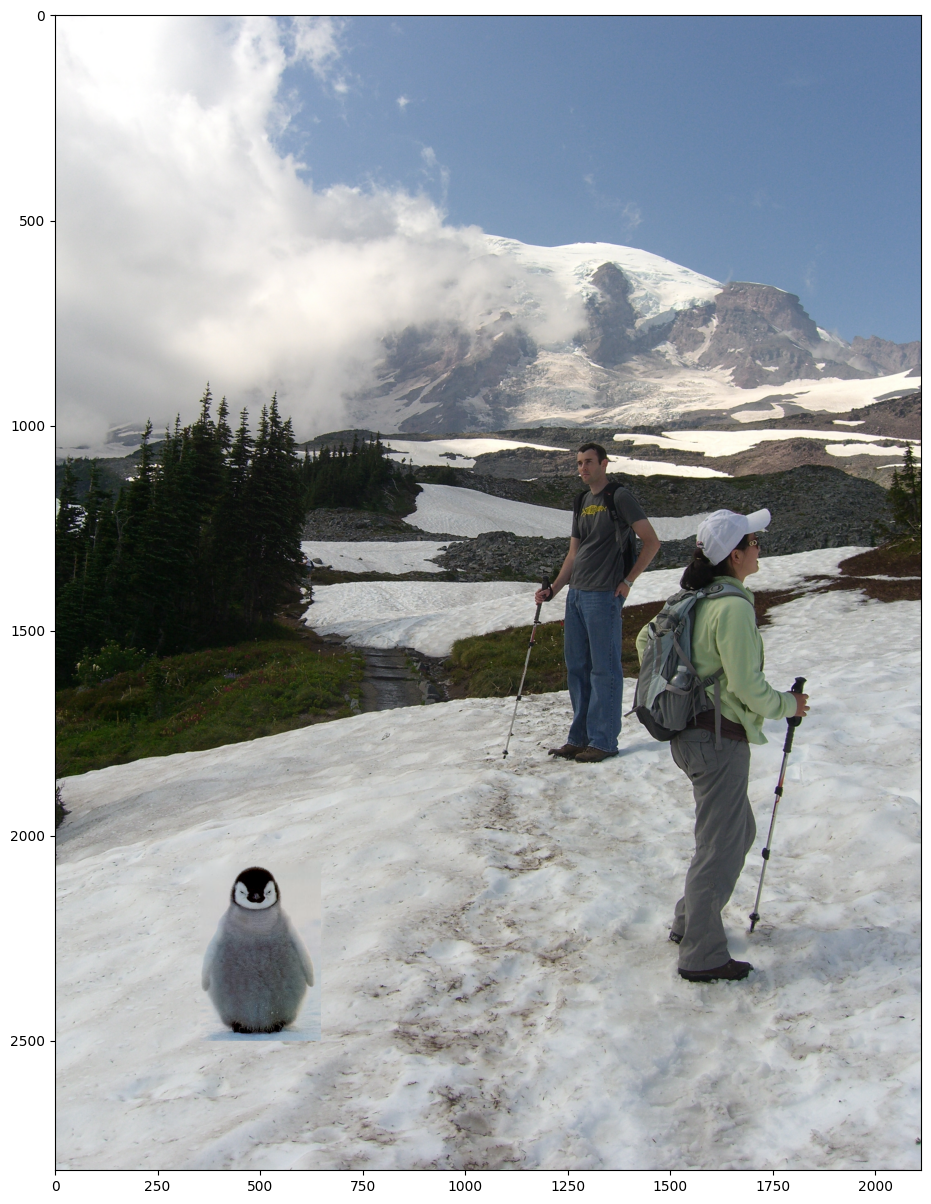

In [40]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
    im_blend = poisson_blend(object_img, object_mask, background_img.copy(), position)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)

## Part 3 Mixed Gradients (20 pts)

In [41]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO 



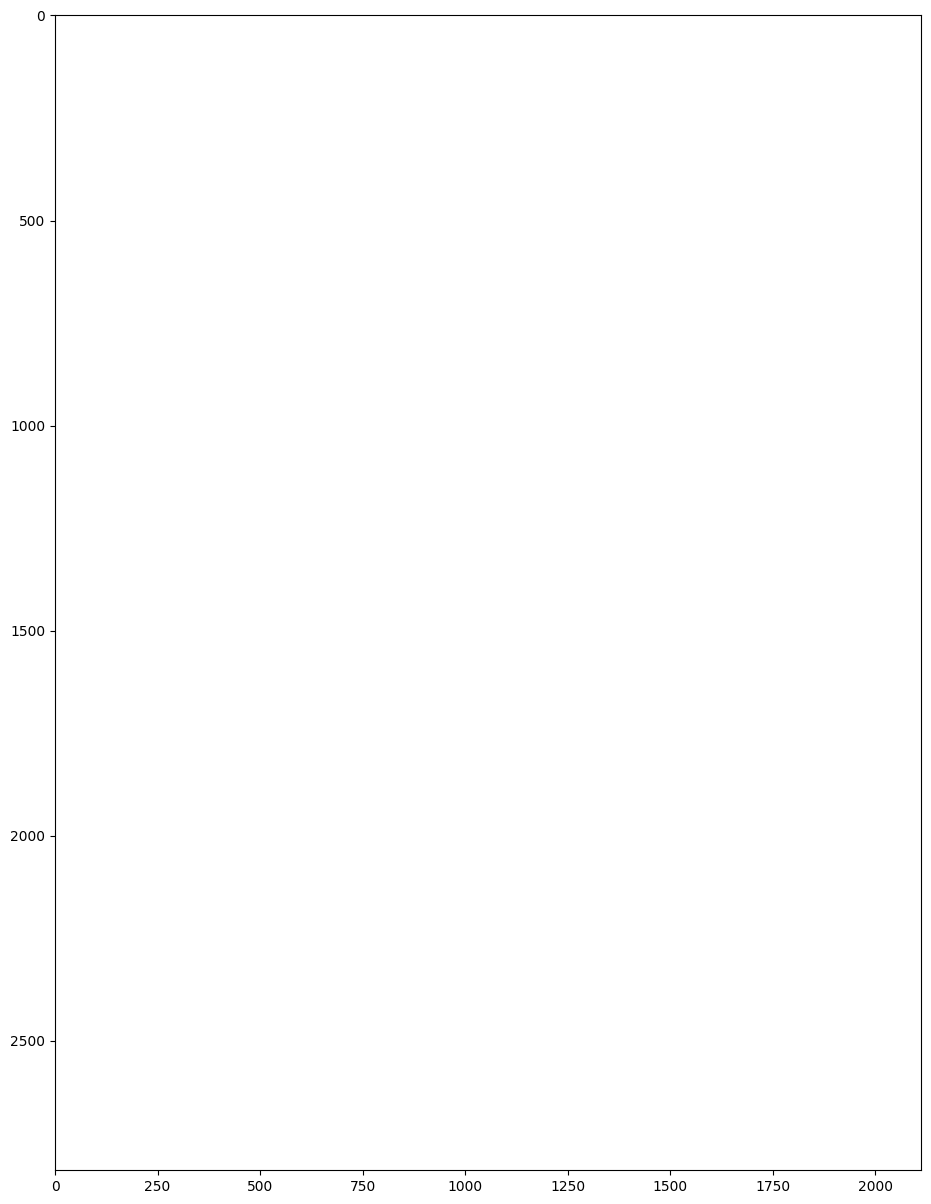

In [42]:
im_mix = np.zeros(background_img.shape)
for b in np.arange(3):
  im_mix[:,:,b] = mixed_blend(object_img, object_mask, background_img[:,:,b].copy(), position)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [43]:
def color2gray(img):
    pass

## Laplacian pyramid blending (20 pts)

In [44]:
def laplacian_blend(object_img, object_mask, bg_img, bg_ul):
  # feel free to change input parameters
    pass

## More gradient domain processing (up to 20 pts)